### Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=4998a750426d0973c7e23e92ef07029e60c489a133217680fb83684babff8174
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import numpy as np
import pandas as pd
from stratmanager import StrategyManager
import sklearn.mixture as mix
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt

### Data Extraction and Returns Overview

In [ ]:
# Extract Data
start_date = "2017-01-01"
end_date = "2023-11-01"
symbol = "AAPL"
strat_mgr = StrategyManager(symbol, start_date, end_date)
df = strat_mgr.df.copy()
df.head()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets
Date,,,,,,,,
2017-01-04 00:00:00-05:00,26.919557,27.072919,26.896321,26.959059,84472400,-0.001119,0.006566,-0.001980
2017-01-05 00:00:00-05:00,26.935820,27.154245,26.910260,27.096153,88774400,0.005085,0.009067,0.004557
2017-01-06 00:00:00-05:00,27.135655,27.456321,27.063623,27.398230,127007600,0.011148,0.014510,0.016101
2017-01-09 00:00:00-05:00,27.407528,27.751430,27.405206,27.649189,134247600,0.009160,0.012634,0.023512
2017-01-10 00:00:00-05:00,27.598062,27.739805,27.488851,27.677067,97848400,0.001008,0.009129,0.021361


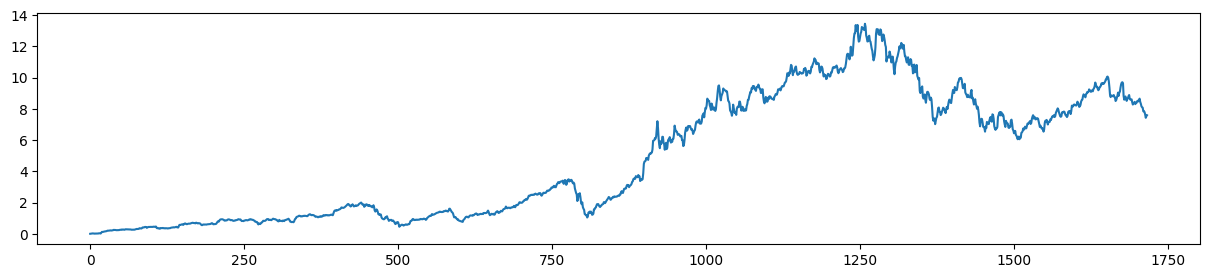

In [ ]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 3))
plt.plot(df["Bench_C_Rets"].values)
plt.show()

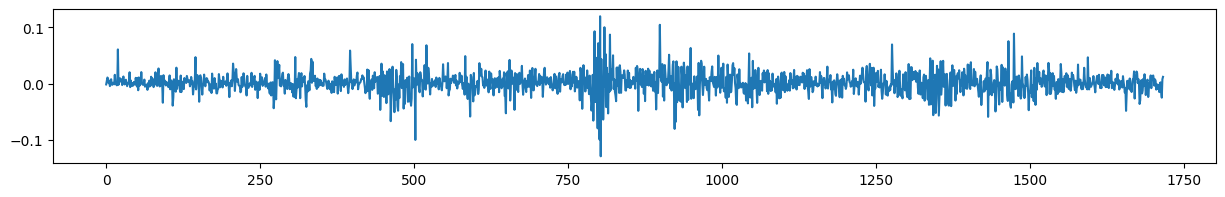

In [ ]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Returns"].values)
plt.show()

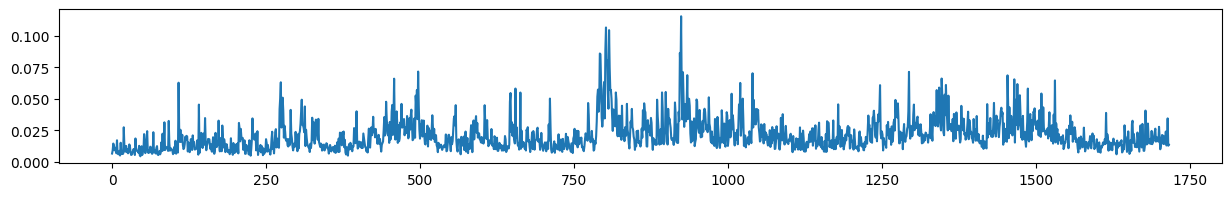

In [ ]:
# Benchmark Range Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Range"].values)
plt.show()

### Feature Engineering - Feature Expansion

In [ ]:
# Create a copy
df_fe = df.copy()

##### Indicators

In [ ]:
# Add RSI
rsi = RSIIndicator(close=df_fe["Close"], window=14).rsi()
df_fe["RSI"] = rsi
df_fe["RSI_Ret"] = df_fe["RSI"] / df_fe["RSI"].shift(1)

In [ ]:
# Add Moving Average
df_fe["MA_12"] = df_fe["Close"].rolling(window=12).mean()
df_fe["MA_21"] = df_fe["Close"].rolling(window=21).mean()

In [ ]:
# Day of Week
df_fe["DOW"] = df_fe.index.dayofweek

In [ ]:
# Rolling Cumulative Returns
df_fe["Roll_Rets"] = df_fe["Returns"].rolling(window=30).sum()

In [ ]:
# Rolling Cumulative Range
df_fe["Avg_Range"] = df_fe["Range"].rolling(window=30).mean()

##### Time Intervals

In [ ]:
# Add Time Intervals
t_steps = [1, 2]
t_features = ["Returns", "Range", "RSI_Ret"]
for ts in t_steps:
    for tf in t_features:
        df_fe[f"{tf}_T{ts}"] = df_fe[tf].shift(ts)

In [ ]:
# Show DataFrame
df_fe.head(3)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04 00:00:00-05:00,26.919557,27.072919,26.896321,26.959059,84472400,-0.001119,0.006566,-0.001980,NaN,NaN,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05 00:00:00-05:00,26.935820,27.154245,26.910260,27.096153,88774400,0.005085,0.009067,0.004557,NaN,NaN,...,NaN,3,NaN,NaN,-0.001119,0.006566,NaN,NaN,NaN,NaN
2017-01-06 00:00:00-05:00,27.135655,27.456321,27.063623,27.398230,127007600,0.011148,0.014510,0.016101,NaN,NaN,...,NaN,4,NaN,NaN,0.005085,0.009067,NaN,-0.001119,0.006566,NaN


### Feature Engineering - Feature Scaling

In [ ]:
# Correct for Stationarity
df_fs = df_fe.copy()
df_fs[["Open", "High", "Low", "Volume"]] = df_fs[["Open", "High", "Low", "Volume"]].pct_change()
df_fs

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04 00:00:00-05:00,NaN,NaN,NaN,26.959059,NaN,-0.001119,0.006566,-0.001980,NaN,NaN,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05 00:00:00-05:00,0.000604,0.003004,0.000518,27.096153,0.050928,0.005085,0.009067,0.004557,NaN,NaN,...,NaN,3,NaN,NaN,-0.001119,0.006566,NaN,NaN,NaN,NaN
2017-01-06 00:00:00-05:00,0.007419,0.011124,0.005699,27.398230,0.430678,0.011148,0.014510,0.016101,NaN,NaN,...,NaN,4,NaN,NaN,0.005085,0.009067,NaN,-0.001119,0.006566,NaN
2017-01-09 00:00:00-05:00,0.010019,0.010748,0.012622,27.649189,0.057004,0.009160,0.012634,0.023512,NaN,NaN,...,NaN,0,NaN,NaN,0.011148,0.014510,NaN,0.005085,0.009067,NaN
2017-01-10 00:00:00-05:00,0.006952,-0.000419,0.003052,27.677067,-0.271135,0.001008,0.009129,0.021361,NaN,NaN,...,NaN,1,NaN,NaN,0.009160,0.012634,NaN,0.011148,0.014510,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-24 00:00:00-04:00,0.012521,-0.001954,0.008945,172.991058,-0.217283,0.002543,0.012948,7.794654,42.025235,1.033421,...,174.771679,1,-0.014853,0.017912,0.000694,0.024010,1.008791,-0.014704,0.016103,0.880764
2023-10-25 00:00:00-04:00,-0.006761,-0.003512,-0.004666,170.657135,0.304460,-0.013492,0.014122,7.638983,37.151332,0.884024,...,174.730834,2,-0.016489,0.017747,0.002543,0.012948,1.033421,0.000694,0.024010,1.008791
2023-10-26 00:00:00-04:00,-0.008785,-0.009708,-0.029183,166.458023,0.235637,-0.024606,0.034466,7.427426,30.334801,0.816520,...,174.562700,3,-0.049877,0.018412,-0.013492,0.014122,0.884024,0.002543,0.012948,1.033421


### Assess Data for ML Readiness

In [ ]:
# Check for NaN
df_fs.dropna(inplace=True)
print(df_fs.isnull().values.any())

False


In [ ]:
# Check for Inf values
dfobj = df_fs.isin([np.inf, -np.inf])
count = np.isinf(dfobj).values.sum()
count

0

In [ ]:
# Check for non-numerical objects
df_fs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1688 entries, 2017-02-15 00:00:00-05:00 to 2023-10-30 00:00:00-04:00
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1688 non-null   float64
 1   High          1688 non-null   float64
 2   Low           1688 non-null   float64
 3   Close         1688 non-null   float64
 4   Volume        1688 non-null   float64
 5   Returns       1688 non-null   float64
 6   Range         1688 non-null   float64
 7   Bench_C_Rets  1688 non-null   float64
 8   RSI           1688 non-null   float64
 9   RSI_Ret       1688 non-null   float64
 10  MA_12         1688 non-null   float64
 11  MA_21         1688 non-null   float64
 12  DOW           1688 non-null   int32  
 13  Roll_Rets     1688 non-null   float64
 14  Avg_Range     1688 non-null   float64
 15  Returns_T1    1688 non-null   float64
 16  Range_T1      1688 non-null   float64
 17  RSI_Ret_T1    1688 non-

In [ ]:
# Describe DataFrame
df_fs.describe()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
count,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,...,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000,1688.000000
mean,0.001182,0.001133,0.001150,97.206654,0.044835,0.001183,0.021376,4.945589,56.118844,1.003880,...,96.358382,2.027251,0.037611,0.021311,0.001184,0.021377,1.003787,0.001184,0.021374,1.003713
std,0.019044,0.016261,0.017253,52.458697,0.337486,0.019215,0.012664,3.980105,12.934588,0.095665,...,52.254250,1.399201,0.099905,0.007732,0.019215,0.012664,0.095579,0.019216,0.012666,0.095525
min,-0.086602,-0.092642,-0.087766,31.587038,-0.712266,-0.128647,0.004394,0.195863,21.030088,0.665809,...,29.433504,0.000000,-0.340127,0.008904,-0.128647,0.004394,0.665809,-0.128647,0.004394,0.665809
25%,-0.007939,-0.006653,-0.006999,44.761901,-0.163117,-0.007772,0.012864,1.107472,46.178511,0.950069,...,44.657018,1.000000,-0.024104,0.015379,-0.007772,0.012864,0.950069,-0.007772,0.012864,0.950069
50%,0.001834,0.001222,0.001983,87.883781,-0.017638,0.001096,0.018183,3.394412,57.291929,1.004009,...,82.604768,2.000000,0.047498,0.019384,0.001096,0.018183,1.004009,0.001096,0.018183,1.004009
75%,0.010303,0.008872,0.010169,146.507462,0.181308,0.011129,0.026351,8.588422,65.219511,1.049622,...,145.163078,3.000000,0.105751,0.026188,0.011129,0.026351,1.049597,0.011129,0.026351,1.049545
max,0.097256,0.105065,0.102018,195.677261,2.628303,0.119808,0.115520,13.451355,92.991079,1.797471,...,191.812050,4.000000,0.338760,0.056268,0.119808,0.115520,1.797471,0.119808,0.115520,1.797471


### Save Data

In [ ]:
# Save DataFrame
df_fs.to_csv(f"/content/drive/MyDrive/ML_Trade/2_Supervised/data/{symbol}.csv")

In [ ]:
# !pip install yfinance==0.2.36
import yfinance as yf
import numpy as np

# Create the class
class StrategyManager():

    # Initialize the class
    def __init__(self, symbol, start_date, end_date):
        self.df = self._extract_data(symbol, start_date, end_date)
        self.sharpe = 0

    # Extract data
    def _extract_data(self, symbol, start_date, end_date):
        tickerData = yf.Ticker(symbol)
        data = tickerData.history(period='1d', start=start_date, end=end_date)
        data = data[["Open", "High", "Low", "Close", "Volume"]]
        data = self._structure_df(data)
        return data

    # Calculates general period returns and volatility
    def _structure_df(self, df):
        df["Returns"] = df["Close"].pct_change()
        df["Range"] = df["High"] / df["Low"] - 1
        df["Bench_C_Rets"], sharpe = self._calculate_returns(df, True)
        self.sharpe = sharpe
        df.dropna(inplace=True)
        return df

    # Adjusts the signal to represent our strategy
    def _set_multiplier(self, direction):
        if direction == "long":
            pos_multiplier = 1
            neg_multiplier = 0
        elif direction == "long_short":
            pos_multiplier = 1
            neg_multiplier = -1
        else:
            pos_multiplier = 0
            neg_multiplier = -1
        return pos_multiplier, neg_multiplier

    # Calculates returns for equity curve
    def _calculate_returns(self, df, is_benchmark):

        # Calculate multiplier
        if not is_benchmark:
            multiplier_1 = df["Signal"]
            multiplier_2 = 1 if "PSignal" not in df.columns else df["PSignal"]
            log_rets = np.log(df["Close"] / df["Close"].shift(1)) * multiplier_1 * multiplier_2
        else:
            multiplier_1 = 1
            multiplier_2 = 1

            # Assume open price on following day to avoid lookahead bias for close calculation
            log_rets = np.log(df["Open"].shift(-1) / df["Close"].shift(1)) * multiplier_1 * multiplier_2

        # Calculate Sharpe Ratio
        sharpe_ratio = self.sharpe_ratio(log_rets)

        # Calculate Cumulative Returns
        c_log_rets = log_rets.cumsum()
        c_log_rets_exp = np.exp(c_log_rets) - 1

        # Return result and Sharpe ratio
        return c_log_rets_exp, sharpe_ratio

    def sharpe_ratio(self, return_series):
        N = 255 # Trading days in the year (change to 365 for crypto)
        rf = 0.005 # Half a percent risk free rare
        mean = return_series.mean() * N -rf
        sigma = return_series.std() * np.sqrt(N)
        sharpe = round(mean / sigma, 3)
        return sharpe

    # Replace Dataframe
    def change_df(self, new_df, drop_cols=[]):
        new_df = new_df.drop(columns=drop_cols)
        self.df = new_df

    # Moving average crossover strategy
    def backtest_ma_crossover(self, period_1, period_2, direction, drop_cols=[]):

        # Set df
        df = self.df

        # Get multipliers
        pos_multiplier, neg_multiplier = self._set_multiplier(direction)

        # Calculate Moving Averages
        if f"MA_{period_1}" or f"MA_{period_2}" not in df.columns:
            df[f"MA_{period_1}"] = df["Close"].rolling(window=period_1).mean()
            df[f"MA_{period_2}"] = df["Close"].rolling(window=period_2).mean()
            df.dropna(inplace=True)

        # Calculate Benchmark Returns
        df["Bench_C_Rets"], sharpe_ratio_bench = self._calculate_returns(df, True)

        # Calculate Signal
        df.loc[df[f"MA_{period_1}"] > df[f"MA_{period_2}"], "Signal"] = pos_multiplier
        df.loc[df[f"MA_{period_1}"] <= df[f"MA_{period_2}"], "Signal"] = neg_multiplier

        # Calculate Strategy Returns
        df["Strat_C_Rets"], sharpe_ratio_strat = self._calculate_returns(df, False)

        # Get values for output
        bench_rets = df["Bench_C_Rets"].values.astype(float)
        strat_rets = df["Strat_C_Rets"].values.astype(float)
        print("Sense check: ", round(df["Close"].values[-1] / df["Close"].values[0] - 1, 3), round(bench_rets[-1], 3))

        # Remove irrelevant features
        if len(drop_cols) > 0:
            df = df.drop(columns=drop_cols)

        # Ensure Latest DF matches
        df = df.dropna()
        self.df = df

        # Return df
        return df, sharpe_ratio_bench, sharpe_ratio_strat

In [ ]:
def preprocess_and_save(symbol, start_date="2012-01-01", end_date="2023-11-01"):
  strat_mgr = StrategyManager(symbol, start_date, end_date)
  df = strat_mgr.df.copy()
  df_fe = df.copy()

  # Add RSI
  rsi = RSIIndicator(close=df_fe["Close"], window=14).rsi()
  df_fe["RSI"] = rsi
  df_fe["RSI_Ret"] = df_fe["RSI"] / df_fe["RSI"].shift(1)

  # Add Moving Average
  df_fe["MA_12"] = df_fe["Close"].rolling(window=12).mean()
  df_fe["MA_21"] = df_fe["Close"].rolling(window=21).mean()

  # Day of Week
  df_fe["DOW"] = df_fe.index.dayofweek

  # Rolling Cumulative Returns
  df_fe["Roll_Rets"] = df_fe["Returns"].rolling(window=30).sum()

  # Rolling Cumulative Range
  df_fe["Avg_Range"] = df_fe["Range"].rolling(window=30).mean()

  # Add Time Intervals
  t_steps = [1, 2]
  t_features = ["Returns", "Range", "RSI_Ret"]
  for ts in t_steps:
      for tf in t_features:
          df_fe[f"{tf}_T{ts}"] = df_fe[tf].shift(ts)

  # Correct for Stationarity
  df_fs = df_fe.copy()
  df_fs[["Open", "High", "Low", "Volume"]] = df_fs[["Open", "High", "Low", "Volume"]].pct_change()

  # Check for NaN
  df_fs.dropna(inplace=True)
  print(df_fs.isnull().values.any())

  # Check for Inf values
  dfobj = df_fs.isin([np.inf, -np.inf])
  count = np.isinf(dfobj).values.sum()
  print(count)

  # Check for non-numerical objects
  print(df_fs.info())

  # Describe DataFrame
  print(df_fs.describe())

  # Save DataFrame
  df_fs.to_csv(f"/content/drive/MyDrive/ML_Trade/2_Supervised/data/{symbol}.csv")

In [ ]:
tickers = ['AMD', 'AMZN', 'ADBE', 'ORCL', 'META', 'GOOGL', 'NVDA', 'TSLA', 'MSFT', 'AAPL']
for ticker in tickers:
  preprocess_and_save(ticker)

False
0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2946 entries, 2012-02-15 00:00:00-05:00 to 2023-10-30 00:00:00-04:00
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2946 non-null   float64
 1   High          2946 non-null   float64
 2   Low           2946 non-null   float64
 3   Close         2946 non-null   float64
 4   Volume        2946 non-null   float64
 5   Returns       2946 non-null   float64
 6   Range         2946 non-null   float64
 7   Bench_C_Rets  2946 non-null   float64
 8   RSI           2946 non-null   float64
 9   RSI_Ret       2946 non-null   float64
 10  MA_12         2946 non-null   float64
 11  MA_21         2946 non-null   float64
 12  DOW           2946 non-null   int32  
 13  Roll_Rets     2946 non-null   float64
 14  Avg_Range     2946 non-null   float64
 15  Returns_T1    2946 non-null   float64
 16  Range_T1      2946 non-null   float64
 17  RSI_Ret_T1    2